In [91]:
import matplotlib.pyplot as plt
import numpy as np
import wandb
api = wandb.Api()

plt.style.use("seaborn-darkgrid")
plt.rcParams["font.family"] = "Lato"

In [112]:
run_ids = {
    3: {
        "dense": {
            "vanilla": ["mvk7jl2n", "6afpe9p7", "3zgzw8jp"],
            "love": ["2iildmam", "3p58u488", "383ju2rw"],
            "ours": ["2ocp3glq", "2efiz492", "3sdge3p8"]
        },
        "sparse": {
            "vanilla": ["1xwmqbl8", "2ei7mhyo", "335m7vx1"],
            "love": ["3q16x9k6", "2sks4g5q", "2zsa40sv"],
            "ours": ["3htegeyy", "2xzy5gny", "20t863f2"],
            "slow": ["2kaq7f90", "s715ju4r", "1egmnjx8"]
        }
    },
    4: {
        "dense": {
            "vanilla": ["28cilrex", "3v81jld2", "171umd95"],
            "love": ["1lbg5xfk", "9roaittz", "uneib2mm"],
            "ours": ["3sdwyxbh", "1q4zuv0z", "2i7h6bhr"],
            "slow": ["22mug2a5", "1zz7rjk8", "1bwsvd9e"]
        },
        "sparse": {
            "vanilla": ["1l9tn8q4", "21wsmfhe", "13dw1czp"],
            "love": ["1rfql2ej", "3tvvoqge", "2uvmvtx6"],
            "ours": ["mfr52l3y", "1ddnbmme", "37sgcxw7"],
            "slow": ["goyyrfdp", "lpvuin0w", "38u0zbgz"]
        }
    },
    5: {
        "dense": {
            "vanilla": ["22odvku4", "vhd8piao", "g1deor4q"],
            "love": ["1qixl53n", "zlfejnlw", "36zat2ba"],
            "ours": ["3ap1ev1w", "36id5863", "3e8vnc1h"]
        },
        "sparse": {
            "vanilla": ["2a4w2mu8", "14mhwixp", "3b32s6nz"],
            "love": ["2oqbal4f", "3rt2r1of", "3inupy4w"],
            "ours": ["mmrkitt8", "39si9yac", "md7x6zpv"],
            "slow": ["2hsqqe0v", "xh5bsves", "1sqqgsjr"],
            "long": ["2pao3eyw", "15prnggt", "2gx58b9l"]
        }
    }
}

3 dense
3 sparse
5 dense
5 sparse


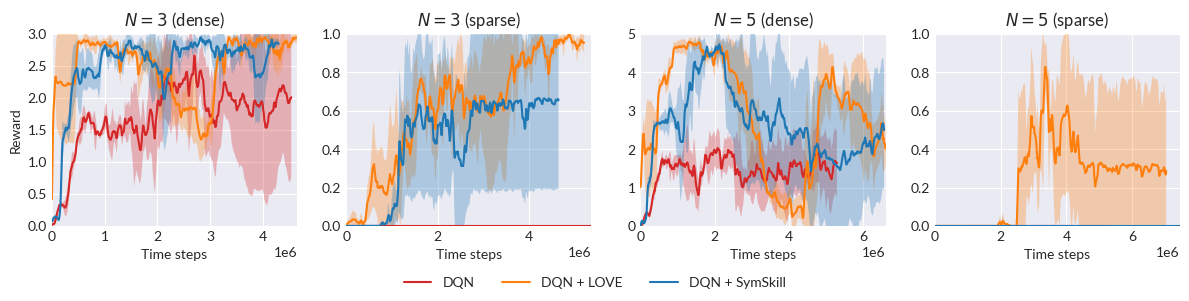

In [148]:
fig, axs = plt.subplots(1, 4)
fig.set_size_inches(12, 3)
fig.subplots_adjust(bottom=0.24, left=0.04, right=0.98)
j = 0
colors = {"ours": 'C0', "love": 'C1', "slow": 'C2', "vanilla": 'C3', "long": 'C4'}
models = {"ours": 'DQN + SymSkill', "love": 'DQN + LOVE', "vanilla": "DQN", "slow": "DQN + SymSkill + more exploration", "long": "DQN + SymSkill + more training"}
for N in [3, 5]:
    for mode in ["dense", "sparse"]:
        print(N, mode)
        all_runs = {key: [api.run("conpole2/LOVE_CompILE/{}".format(run_ids[N][mode][key][i])).history() for i in range(3)] for key in run_ids[N][mode]}
        all_max_steps = {key: min(run["total_steps"].iloc[-1] for run in runs) for key, runs in all_runs.items()}
        all_time_steps = {key: np.arange(0, max_steps, 10000) for key, max_steps in all_max_steps.items()}
        all_runs_new = {key: np.vstack([np.interp(all_time_steps[key], run["total_steps"], run["reward/test"]) for run in runs]) for key, runs in all_runs.items()}
        all_runs_mean = {key: np.mean(runs_new, axis=0) for key, runs_new in all_runs_new.items()}
        all_runs_stderr = {key: np.std(runs_new, axis=0) for key, runs_new in all_runs_new.items()}
        axs[j].set_xlim([0, max(all_max_steps.values())])
        axs[j].set_ylim([0, N if mode == "dense" else 1])
        axs[j].set_xlabel("Time steps")
        if j == 0:
            axs[j].set_ylabel("Reward")
        axs[j].title.set_text("$N = {}$ ({})".format(N, mode))
        for key in all_runs_mean:
            if key == "slow" or key == "long":
                continue
            time_steps = all_time_steps[key]
            runs_mean = all_runs_mean[key]
            runs_stderr = all_runs_stderr[key]
            if j == 0:
                axs[j].plot(time_steps, runs_mean, color=colors[key], label=models[key])
            else:
                axs[j].plot(time_steps, runs_mean, color=colors[key])
            axs[j].fill_between(time_steps, runs_mean-runs_stderr, runs_mean+runs_stderr, alpha=0.3, color=colors[key], edgecolor="none")
        j += 1
fig.legend(loc=8, ncol=3)
fig.savefig("grid_learning_curves.pdf")

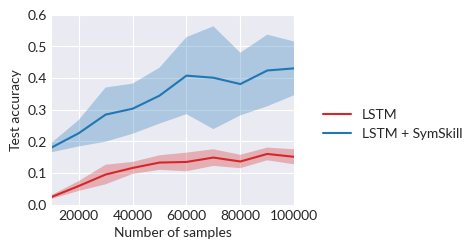

In [147]:
format_str = "SCAN_main_experiment_run0-length_{}seed{}"
fig, ax = plt.subplots(figsize=(4.8, 2.6))
fig.subplots_adjust(right=0.63, bottom=0.15)
ax.set_ylabel("Test accuracy")
ax.set_xlabel("Number of samples")
ax.set_ylim([0, 0.6])
ax.set_xlim([10000, 100000])
time_steps = np.arange(1, 11) * 10000
colors = {'': 'C3', "loop_": 'C0'}
models = {'': "LSTM", "loop_": "LSTM + SymSkill"}
for model in ['', "loop_"]:
    runs = [api.run("conpole2/SCAN_main_experiment_run0/{}".format(format_str.format(model, seed))).history() for seed in range(10)]
    runs_new = np.vstack([run["valid_acc"] for run in runs])
    runs_mean = np.mean(runs_new, axis=0)
    runs_stderr = np.std(runs_new, axis=0)
    ax.plot(time_steps, runs_mean, color=colors[model], label=models[model])
    ax.fill_between(time_steps, runs_mean-runs_stderr, runs_mean+runs_stderr, alpha=0.3, color=colors[model], edgecolor="none")
fig.legend(loc=7)
fig.savefig("scan_learning_curves.pdf")